# Home Sales 

This data set is from the [Kaggle Advanced Home Sales Regression](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) challenge. Unfortunately the data is not available unless you sign up for Kaggle and agree to the restrictions from the data set. However this notebook is more to demonstrate the use of iPython widgets and sliders to create a simple application for determining home sales.

In [1]:
%matplotlib inline

import os 
import numpy as np
import pandas as pd
import seaborn as sns 

## Data Exploration

In [28]:
data = pd.read_csv(os.path.join('data', 'train.csv'))
print("Data set of {} instances and {} attributes".format(*data.shape))
data.head()

Data set of 1460 instances and 81 attributes


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


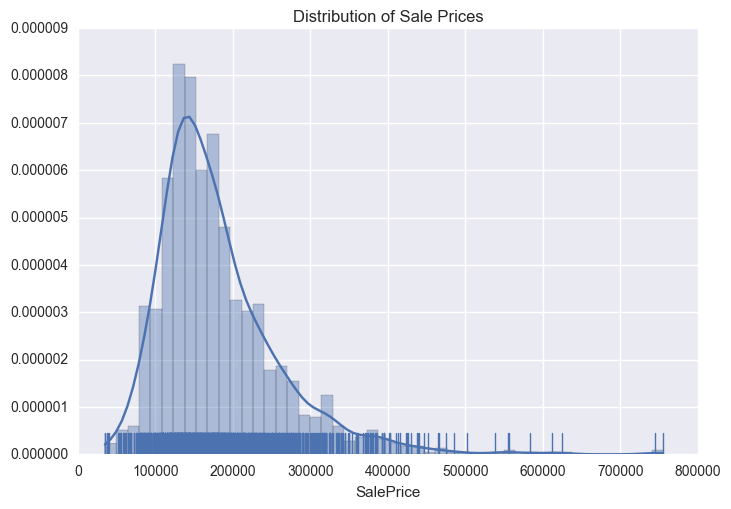

In [43]:
g = sns.distplot(data.SalePrice, rug=True, kde=True)
t = g.set_title("Distribution of Sale Prices")

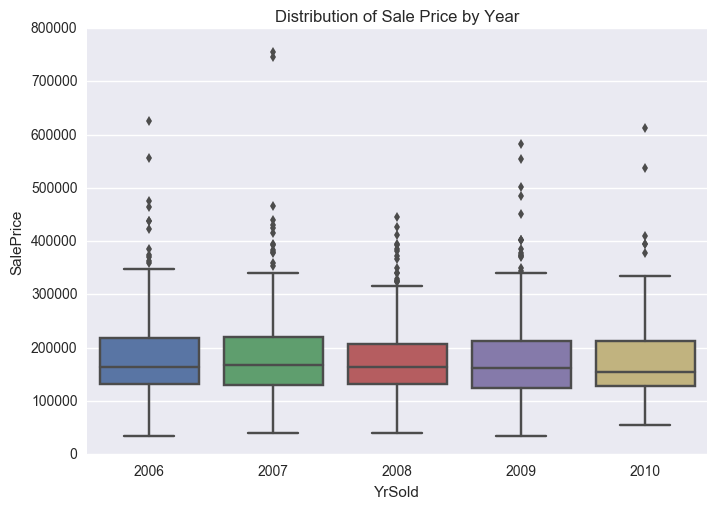

In [44]:
g = sns.boxplot(y='SalePrice', x='YrSold', data=data)
t = g.set_title("Distribution of Sale Price by Year")

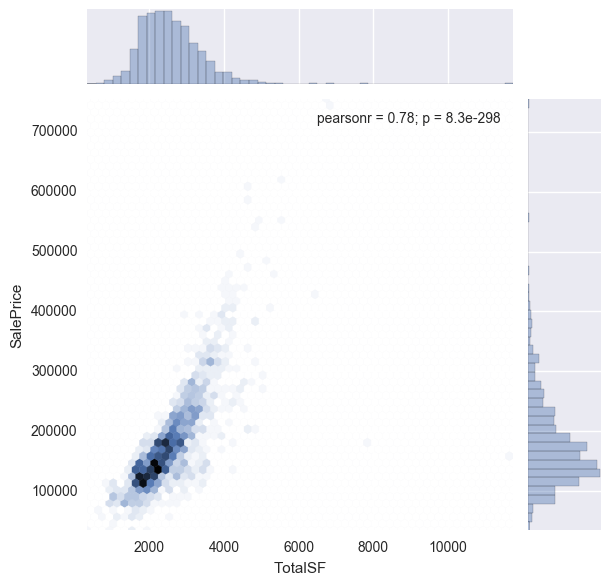

In [64]:
data["TotalSF"] = data.TotalBsmtSF + data.GrLivArea
g = sns.jointplot(y="SalePrice", x="TotalSF", data=data, kind="hex")

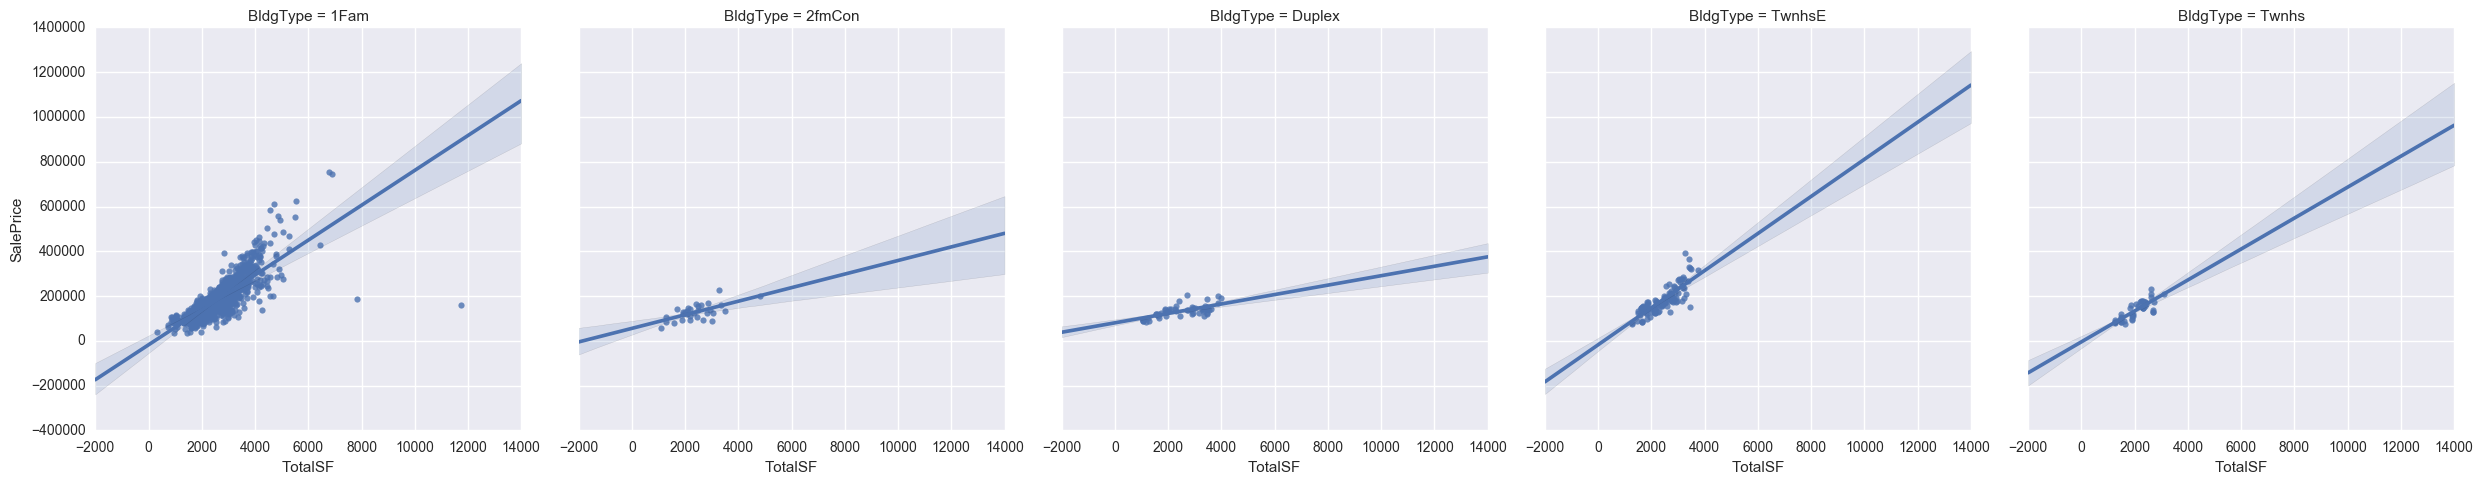

In [63]:
data["TotalSF"] = data.TotalBsmtSF + data.GrLivArea
g = sns.lmplot(y="SalePrice", x="TotalSF", data=data, col="BldgType")

## Data Loading

Kaggle has provided a train.csv and test.csv file with headers. However, while the train.csv has the target, `SalePrice` included in the CSV file, the test.csv does not. For simplicy, the data loader will just return a bunch with the data and target split up and the test data and a description.

In [67]:
from sklearn.datasets.base import Bunch

def load_data(path="data", train="train.csv", test="test.csv", descr="data_description.txt", target="SalePrice"):
    
    # Load the training data frame and split into X, y data frames
    train  = pd.read_csv(os.path.join(path, train))
    feats  = [col for col in train.columns if col != target]
    data   = train[feats]
    target = train[target]
    
    # Load the test data frame (no answers provided)
    test = pd.read_csv(os.path.join(path, test))
    
    # Read the description 
    with open(os.path.join(path, descr)) as f:
        descr = f.read() 
    
    return Bunch(
        data=data,
        target=target,
        test=test,
        DESCR=descr,
    )

data = load_data()

## Feature Extraction 

In [20]:
print(data.DESCR)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [71]:
CATEGORICAL = [
    "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", 
    "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType",
    "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
    "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", 
    "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", 
    "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish", 
    "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature", 
    "SaleType", "SaleCondition", 
]

In [77]:
for col in [
    "Alley", "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
    "BsmtFinType2", "Electrical", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", 
    "GarageCond", "PoolQC", "Fence", "MiscFeature", 
]:
    data.data[col] = data.data[col].apply(str)

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import LabelEncoder

class EncodeCategorical(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        self.columns = list(columns) if columns is not None else None
        self.encoders = None 
    
    def fit(self, data, target=None):
        if self.columns is None:
            self.columns = list(data.columns)
        
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns
        }
        
        return self
    
    def transform(self, data):
        data = data.copy()
        
        for column, encoder in self.encoders.items():
            data[column] = encoder.transform(data[column])
        
        return data 

EncodeCategorical(CATEGORICAL).fit_transform(data.data).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,0,3,4,4,0,2,2008,8,4
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,0,3,4,4,0,5,2007,8,4
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,0,3,4,4,0,9,2008,8,4
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,0,3,4,4,0,2,2006,8,0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,0,3,4,4,0,12,2008,8,4


In [101]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import Normalizer, OneHotEncoder, Imputer

pipeline = Pipeline([
        ('encoder', EncodeCategorical(CATEGORICAL)), 
        ('imputer', Imputer('NaN', 'mean')),
        ('normalize', Normalizer()), 
    ])

X = pipeline.fit_transform(data.data)
y = data.target 

In [85]:
from sklearn.linear_model import RidgeCV, LassoCV 
from sklearn.cross_validation import train_test_split as tts 

In [104]:
X, Xt, y, yt = tts(X, y, test_size=0.2)
print(X.shape, y.shape)
print(Xt.shape, yt.shape)

(934, 80) (934,)
(234, 80) (234,)


In [110]:
alphas = np.logspace(-10, -2, 200)
ridge  = RidgeCV(alphas=alphas)
lasso  = LassoCV(alphas=alphas)

ridge.fit(X, y)
lasso.fit(X, y)

scores = [
    ridge.score(Xt, yt),
    lasso.score(Xt, yt),
]

print("Ridge: {:0.3f}, Lasso: {:0.3f}".format(*scores))

/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Ridge: 0.716, Lasso: 0.714


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
